In [4]:
import numpy as np
import vegas as ve
from math import *
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import interpolate
import scipy
import pylab

In [17]:
lensed = np.genfromtxt("./data/cl/explanatory33_cl_lensed.dat")

In [18]:
unlensed = np.genfromtxt("./data/cl/explanatory33_cl.dat")

In [19]:
kappa = np.genfromtxt("./data/cl/explanatory33_cl_lensed.dat")

In [110]:
T_cmb = 2.729 
#need to convert dimensionless l^2/(2*pi)c_l to dimensionful c_l
cl_len = interpolate.interp1d(lensed[:,0],2*np.pi*np.divide(lensed[:,1],np.power(lensed[:,0],2))*10**12*T_cmb**2.0)
cl_unlen = interpolate.interp1d(unlensed[:,0],2*np.pi*np.divide(unlensed[:,1],np.power(unlensed[:,0],2))*10**12*T_cmb**2.0)

#c_kappakappa = l^4 c_phiphi (but it is already l^2 c_phipih)
cl_kapkap = interpolate.interp1d(kappa[:,0],2*np.pi*kappa[:,-3]*kappa[:,0]**2.0/4)

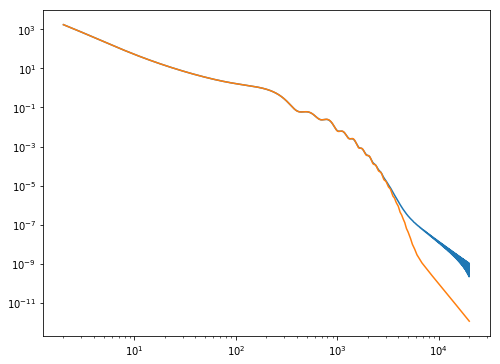

In [111]:
lmax=20000 #maximum for use
plt.loglog(lensed[:lmax,0],cl_len(lensed[:lmax,0]))
plt.loglog(unlensed[:lmax,0],cl_unlen(unlensed[:lmax,0]))

In [112]:
def integrand_q(dvec,FWHM,noise_lev,l):
  # Hu, De Deo and Vale 2001 (HDV), between equation 17 and 18
    l1,phi1= dvec #instead of lx, ly, we are using |l| and phi
    l2 = calc_l2(l,l1,phi1) #calculating l2
    
    T1 = l*l1*cos(phi1) #first term of integral, dot product
    T2 = WTT(l1,noise_lev, FWHM) #HDV, eq 21
    T3 = WT(l2,noise_lev, FWHM) #HDV, eq 19
    T4 = 1.0  #C^T = 1.0
    T5 = fTT(l,l1,l2,phi1) #HDV, eq 17
    T6 = l #from the change of variables to polar instead of lx, ly
    return T1*T2*T3*T4*T5*T6

def Cl_noise(l, noise_lev, FWHM):     # noise level in muK-arcmin, and beam FWHM in arcmin

    noise_lev = noise_lev * np.pi / (60. * 180)     # convert muK-arcmin to muK-rad
    FWHM = FWHM * np.pi / (60. * 180)               # convert arcmin to rad
    return noise_lev**2 * np.exp(l*(l+1.) * FWHM**2 / (8. * np.log(2)))

def fTT(l,l1,l2,phi1):
    #HDV eq 17
    try:
        return cl_unlen(l1)*l*l1*cos(phi1)+cl_unlen(l2)*(l1*l*cos(phi1)-l1**2.)
    except: #exception if outside of interpolation range
        return 0.
    
def WTT(l,noise_lev, FWHM):
    if l > 2000: #cutoff from HDV eq 20
        return 0.
    else: #HDV eq 21
        return cl_unlen(l)/(cl_len(l)+Cl_noise(l, noise_lev, FWHM))

def WT(l,noise_lev, FWHM):
    try: #HDV eq. 19
        return 1./(cl_len(l)+Cl_noise(l, noise_lev, FWHM))
    except: #exception if outside of integration range, could alternatively 
        #just assume C_l is smaller than noise (and only use noise), but not really valid for low-noise limit
        return 0.0#1./(Cl_noise(l, noise_lev, FWHM))

def calc_l2(l,l1,phi1): #law of cosines
    return sqrt(l**2.+l1**2.-2.*l1*l*cos(phi1))


In [118]:
global noise_lev
global FWHM
def noise_curve(noise,FWHM_in,lrange = np.logspace(log10(20),log10(20000),20)):
    def integrand_nl(dvec):
        return integrand_q(dvec,FWHM_in,noise,lq)
    integ = ve.Integrator([[10, 20000], [0, 2*np.pi]])
    results = np.zeros(20)
    global lq
    for i,l in enumerate(lrange):
        lq = l
        #note from equation 17/18 we take out the (2*np.pi)^2 outside of the integral
        #2/l^2 prefactor
        result = 2*integ(integrand_nl, nitn=10, neval=1000)/l**2/(2*np.pi)**2
        print i,l, result.val
        results[i]=result.val 
    Att = interpolate.interp1d(lrange,1./results) #need to invert final result 
    return Att

In [119]:
um1b = noise_curve(1.,  18./60.)

0 20.0 8835786236.6
1 28.7689977658 25362799210.8
2 41.3827616223 34902139806.7
3 59.5270288326 45209043718.7
4 85.6266479744 65438676645.3
5 123.169642213 1.00137551031e+11
6 177.173358082 1.46084883911e+11
7 254.854997141 2.25595272384e+11
8 366.596142166 3.61646519937e+11
9 527.330179746 6.78602425701e+11
10 758.538038146 1.59128449345e+12
11 1091.11895623 5.24638958381e+12
12 1569.5199407 2.68718718005e+13
13 2257.67578337 2.49304101634e+14
14 3247.55347838 3.04376736282e+15
15 4671.44293818 3.1949837329e+16
16 6719.63657257 1.3576449846e+17
17 9665.86047714 2.73577150467e+17
18 13903.8559236 3.90558148845e+17
19 20000.0 4.31807629628e+17


In [120]:
um6b = noise_curve(6.,  18./60.)

0 20.0 15571863105.6
1 28.7689977658 22534733429.6
2 41.3827616223 31353604648.1
3 59.5270288326 43693436532.0
4 85.6266479744 68894606141.3
5 123.169642213 95138243685.4
6 177.173358082 1.47590771354e+11
7 254.854997141 2.21961693758e+11
8 366.596142166 3.6149904366e+11
9 527.330179746 6.81023207546e+11
10 758.538038146 1.6905838725e+12
11 1091.11895623 5.34410940724e+12
12 1569.5199407 2.46908825798e+13
13 2257.67578337 1.60577853313e+14
14 3247.55347838 1.04849560287e+15
15 4671.44293818 3.83690385256e+15
16 6719.63657257 6.45900968901e+15
17 9665.86047714 8.85819487289e+15
18 13903.8559236 1.10822673009e+16
19 20000.0 1.1891339746e+16


In [121]:
um01b = noise_curve(0.1, 18./60.)

0 20.0 11021851119.3
1 28.7689977658 21145776911.1
2 41.3827616223 33550090589.6
3 59.5270288326 50771292030.7
4 85.6266479744 66209902698.5
5 123.169642213 94490587616.9
6 177.173358082 1.50788086113e+11
7 254.854997141 2.24774992113e+11
8 366.596142166 3.89923062458e+11
9 527.330179746 7.45185710898e+11
10 758.538038146 1.72938077309e+12
11 1091.11895623 5.65878948258e+12
12 1569.5199407 2.87036033434e+13
13 2257.67578337 2.49918521486e+14
14 3247.55347838 3.30415809473e+15
15 4671.44293818 4.40591172081e+16
16 6719.63657257 3.47266442317e+17
17 9665.86047714 2.01062163692e+18
18 13903.8559236 1.02329408491e+19
19 20000.0 3.07571378222e+19


In [122]:
um_no = noise_curve(0.0, 18./60.)

0 20.0 20962495063.1
1 28.7689977658 23289728706.2
2 41.3827616223 35676412248.7
3 59.5270288326 47421721303.6
4 85.6266479744 65505256686.2
5 123.169642213 98636956296.7
6 177.173358082 1.46717166562e+11
7 254.854997141 2.24789910842e+11
8 366.596142166 3.87746366213e+11
9 527.330179746 7.35940653702e+11
10 758.538038146 1.74909500283e+12
11 1091.11895623 5.67204458134e+12
12 1569.5199407 2.89606583974e+13
13 2257.67578337 2.50062514043e+14
14 3247.55347838 3.39973909903e+15
15 4671.44293818 4.4619109366e+16
16 6719.63657257 3.51595959905e+17
17 9665.86047714 2.17608963382e+18
18 13903.8559236 1.41322638858e+19
19 20000.0 1.49474748799e+20


(40, 20000)

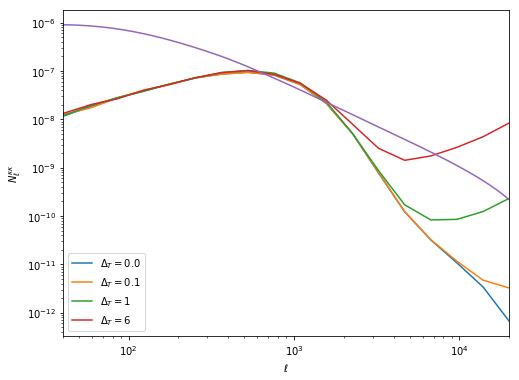

In [127]:
pylab.rcParams['figure.figsize'] = (8., 6.0)
lrange = np.logspace(log10(20),log10(20000),20)
fact = lrange**2./4 #convert from N_dd to N_kappakapp according to unpublished paper
plt.loglog(lrange,um_no(lrange)*fact,label="$\Delta_T = 0.0$")
plt.loglog(lrange,um01b(lrange)*fact,label="$\Delta_T = 0.1$")
plt.loglog(lrange,um1b(lrange)*fact,label="$\Delta_T = 1.$")
plt.loglog(lrange,um6b(lrange)*fact,label="$\Delta_T = 6.$")
plt.legend(loc=3)
plt.ylabel("$N^{\kappa\kappa}_\ell$")
plt.xlabel("$\ell$")
plt.plot(kappa[:,0],cl_phi(kappa[:,0]))
plt.xlim([40,20000])